In [1]:
import pandas as pd
import numpy as np

import torch
import numpy as np
import pandas as pd
import pickle
import multiprocessing
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


def get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42):
    """ Get a list of index values for Validation set from a dataset

    Arguments:
        n : int, Total number of elements in the data set.
        cv_idx : int, starting index [idx_start = cv_idx*int(val_pct*n)]
        val_pct : (int, float), validation set percentage
        seed : seed value for RandomState

    Returns:
        list of indexes
    """
    np.random.seed(seed)
    n_val = int(val_pct * n)
    idx_start = cv_idx * n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start + n_val]


def split_by_idx(idxs, *a):
    """
    Split each array passed as *a, to a pair of arrays like this (elements selected by idxs,  the remaining elements)
    This can be used to split multiple arrays containing training data to validation and training set.

    :param idxs [int]: list of indexes selected
    :param a list: list of np.array, each array should have same amount of elements in the first dimension
    :return: list of tuples, each containing a split of corresponding array from *a.
            First element of each tuple is an array composed from elements selected by idxs,
            second element is an array of remaining elements.
    """
    mask = np.zeros(len(a[0]), dtype=bool)
    mask[np.array(idxs)] = True
    return [(o[mask], o[~mask]) for o in a]


class AutoEncoder(object):

    def __init__(self, data, validation_perc=0.2, lr=0.001,
                 intermediate_size=1000, encoded_size=100):

        # create training dataloader and validation tensor
        self.data = data
        self.val_idxs = get_cv_idxs(n=data.shape[0], val_pct=validation_perc)
        [(self.val, self.train)] = split_by_idx(self.val_idxs, data)
        self.dataset = AETrainingData(self.train)
        self.dataloader = DataLoader(self.dataset, batch_size=80, shuffle=True,
                                     num_workers=multiprocessing.cpu_count())
        #print('datal=',self.dataloader)
        self.val = torch.from_numpy(self.val.values).\
            type(torch.FloatTensor).cuda()

        # instantiate the encoder and decoder nets
        size = data.shape[1]
        self.encoder = Encoder(size, intermediate_size, encoded_size).cuda()
        self.decoder = Decoder(size, intermediate_size, encoded_size).cuda()

        # instantiate the optimizers
        self.encoder_optimizer = optim.Adam(
            self.encoder.parameters(), lr=lr, weight_decay=1e-8)
        self.decoder_optimizer = optim.Adam(
            self.decoder.parameters(), lr=lr, weight_decay=1e-8)

        # instantiate the loss criterion
        self.criterion = nn.MSELoss(reduction='mean')

        self.train_losses = []
        self.val_losses = []

    def train_step(self, input_tensor, target_tensor):
        # clear the gradients in the optimizers
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        # Forward pass through
        encoded_representation = self.encoder(input_tensor)
        reconstruction = self.decoder(encoded_representation)

        # Compute the loss
        loss = self.criterion(reconstruction, target_tensor)

        # Compute the gradients
        loss.backward()

        # Step the optimizers to update the model weights
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        # Return the loss value to track training progress
        return loss.item()
    
    def reset(self, train=True):
        # due to dropout the network behaves differently in training and
        # evaluation modes
        if train: self.encoder.train(); self.decoder.train()
        else: self.encoder.eval(); self.decoder.eval()

    def get_val_loss(self, input_tensor, target_tensor):
        self.reset(train=False)
        encoded = self.encoder(input_tensor)
        decoded = self.decoder(encoded)
        loss = self.criterion(decoded, target_tensor)
        return loss.item()

    def train_loop(self, epochs, print_every_n_batches=20):

        # Cycle through epochs
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')

            # Cycle through batches
            for i, batch in enumerate(self.dataloader):
                #print(i,batch)
                
                self.reset(train=True)

                input_tensor = batch['input'].cuda()
                target_tensor = batch['target'].cuda()

                loss = self.train_step(input_tensor, target_tensor)

                if i % print_every_n_batches == 0 and i != 0:
                    #print('i=',i)
                    val_loss = self.get_val_loss(self.val, self.val)
                    print(f'train loss: {round(loss, 8)} | ' +
                          f'validation loss: {round(val_loss, 8)}')
                    self.train_losses.append(loss)
                    self.val_losses.append(val_loss)

    def get_encoded_representations(self):
        to_encode = torch.from_numpy(self.data.values).type(
            torch.FloatTensor).cuda()
        self.reset(train=False)
        encodings = self.encoder(to_encode).cpu().data.numpy()
        return encodings


class AETrainingData(Dataset):
    """
    Format the training dataset to be input into the auto encoder.
    Takes in dataframe and converts it to a PyTorch Tensor
    """

    def __init__(self, x_train):
        self.x = x_train

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        """
        Returns a example from the data set as a pytorch tensor.
        """
        # Get example/target pair at idx as numpy arrays
        x, y = self.x.iloc[idx].values, self.x.iloc[idx].values

        # Convert to torch tensor
        x = torch.from_numpy(x).type(torch.FloatTensor)
        y = torch.from_numpy(y).type(torch.FloatTensor)

        # Return pair
        return {'input': x, 'target': y}


class Encoder(nn.Module):
    def __init__(self, input_size, intermediate_size, encoding_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, intermediate_size),
            nn.BatchNorm1d(intermediate_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(intermediate_size, encoding_size),
            nn.BatchNorm1d(encoding_size),
            nn.ReLU(True),
            nn.Dropout(0.2))

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, output_size, intermediate_size, encoding_size):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(encoding_size, intermediate_size),
            nn.BatchNorm1d(intermediate_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(intermediate_size, output_size),
            nn.BatchNorm1d(output_size),
            nn.Sigmoid())

    def forward(self, x):
        x = self.decoder(x)
        return x


In [2]:
with open(f'tfidf_matrix.pkl', 'rb') as fh:
    tfidf_df1 = pickle.load(fh)

In [3]:
ae2 = AutoEncoder(tfidf_df1, validation_perc=0.1, lr=1e-3, intermediate_size=1000, encoded_size=100)

In [4]:
ae2.train_loop(epochs=50)

Epoch 1/50
train loss: 0.23035559 | validation loss: 0.19958511
train loss: 0.2255806 | validation loss: 0.18496141
train loss: 0.22160557 | validation loss: 0.19805941
train loss: 0.21471344 | validation loss: 0.21178354
train loss: 0.21147519 | validation loss: 0.21945158
train loss: 0.23699127 | validation loss: 0.21265353
Epoch 2/50
train loss: 0.20633955 | validation loss: 0.20232187
train loss: 0.19665839 | validation loss: 0.198102
train loss: 0.21075101 | validation loss: 0.19251344
train loss: 0.18631597 | validation loss: 0.18950228
train loss: 0.18466131 | validation loss: 0.18583505
train loss: 0.22263968 | validation loss: 0.17989182
Epoch 3/50
train loss: 0.18811902 | validation loss: 0.17565715
train loss: 0.17775609 | validation loss: 0.16970487
train loss: 0.16801497 | validation loss: 0.1693321
train loss: 0.16336116 | validation loss: 0.16715437
train loss: 0.16123529 | validation loss: 0.15827794
train loss: 0.23153275 | validation loss: 0.1553639
Epoch 4/50
train l

In [4]:
ae2.train_loop(epochs=50)

Epoch 1/50
train loss: 0.23771359 | validation loss: 0.17911133
train loss: 0.23094685 | validation loss: 0.17697765
train loss: 0.22993343 | validation loss: 0.1890208
train loss: 0.2222064 | validation loss: 0.20608068
train loss: 0.21402717 | validation loss: 0.22645964
train loss: 0.22997753 | validation loss: 0.2112163
train loss: 0.21662831 | validation loss: 0.21819498
Epoch 2/50
train loss: 0.20056781 | validation loss: 0.20000005
train loss: 0.20315029 | validation loss: 0.19036616
train loss: 0.18663189 | validation loss: 0.18930939
train loss: 0.18544023 | validation loss: 0.18341944
train loss: 0.18255842 | validation loss: 0.17915855
train loss: 0.18749246 | validation loss: 0.17355341
train loss: 0.17363562 | validation loss: 0.18347029
Epoch 3/50
train loss: 0.16478515 | validation loss: 0.1689038
train loss: 0.1599728 | validation loss: 0.16098291
train loss: 0.16560428 | validation loss: 0.1541903
train loss: 0.15257432 | validation loss: 0.16424781
train loss: 0.16931

In [6]:
ae2.train_loop(epochs=20)

Epoch 1/20
train loss: 0.00113672 | validation loss: 0.00114854
train loss: 0.00114815 | validation loss: 0.00114858
train loss: 0.00117934 | validation loss: 0.0011341
train loss: 0.00110361 | validation loss: 0.00113399
train loss: 0.00112961 | validation loss: 0.00112154
train loss: 0.00107876 | validation loss: 0.00111752
train loss: 0.00109254 | validation loss: 0.00110429
Epoch 2/20
train loss: 0.00107727 | validation loss: 0.00108613
train loss: 0.0010588 | validation loss: 0.00107455
train loss: 0.00105941 | validation loss: 0.00106821
train loss: 0.00105263 | validation loss: 0.00105551
train loss: 0.00104059 | validation loss: 0.0010531
train loss: 0.00102186 | validation loss: 0.00104074
train loss: 0.00100738 | validation loss: 0.0010241
Epoch 3/20
train loss: 0.00101171 | validation loss: 0.00101985
train loss: 0.00099627 | validation loss: 0.00100597
train loss: 0.00097652 | validation loss: 0.00099522
train loss: 0.00098014 | validation loss: 0.00099138
train loss: 0.000

In [6]:
ae2.train_loop(epochs=20)

Epoch 1/20
train loss: 0.00483709 | validation loss: 0.00419374
train loss: 0.00456898 | validation loss: 0.00411724
train loss: 0.00374448 | validation loss: 0.00391408
train loss: 0.00399702 | validation loss: 0.00399422
train loss: 0.00364753 | validation loss: 0.00387804
train loss: 0.00360628 | validation loss: 0.00387233
train loss: 0.00377109 | validation loss: 0.00387323
Epoch 2/20
train loss: 0.0034969 | validation loss: 0.00373813
train loss: 0.00407556 | validation loss: 0.00378379
train loss: 0.00424756 | validation loss: 0.00360743
train loss: 0.00341805 | validation loss: 0.00359657
train loss: 0.00342164 | validation loss: 0.00349367
train loss: 0.00363088 | validation loss: 0.00356519
train loss: 0.00328553 | validation loss: 0.00342205
Epoch 3/20
train loss: 0.00319173 | validation loss: 0.00330015
train loss: 0.00339235 | validation loss: 0.00339379
train loss: 0.00313502 | validation loss: 0.00331523
train loss: 0.00309889 | validation loss: 0.00327918
train loss: 0.

In [7]:
ae2.train_loop(epochs=20)

Epoch 1/30
train loss: 0.00085451 | validation loss: 0.00086411
train loss: 0.00085764 | validation loss: 0.0008596
train loss: 0.00086491 | validation loss: 0.00085619
train loss: 0.00083027 | validation loss: 0.00085341
train loss: 0.00083225 | validation loss: 0.00084137
train loss: 0.00082513 | validation loss: 0.00083224
train loss: 0.00085217 | validation loss: 0.00084115
Epoch 2/30
train loss: 0.0008426 | validation loss: 0.00082214
train loss: 0.00079645 | validation loss: 0.00080952
train loss: 0.00079475 | validation loss: 0.00079879
train loss: 0.00078409 | validation loss: 0.00079092
train loss: 0.00079052 | validation loss: 0.00078854
train loss: 0.00076746 | validation loss: 0.000783
train loss: 0.00076167 | validation loss: 0.00077099
Epoch 3/30
train loss: 0.00075607 | validation loss: 0.00075933
train loss: 0.00075809 | validation loss: 0.0007677
train loss: 0.00075267 | validation loss: 0.00075541
train loss: 0.00073959 | validation loss: 0.00075005
train loss: 0.0007

In [7]:
losses2 = pd.DataFrame(data=list(zip(ae2.train_losses, ae2.val_losses)), columns=['train_loss', 'validation_loss'])
losses2['epoch'] = (losses2.index + 1) / 3

Text(0.5, 1.0, 'autoencoder loss over time')

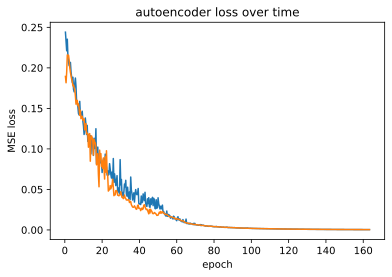

In [8]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots()
ax.plot(losses2['epoch'], losses2['train_loss'])
ax.plot(losses2['epoch'], losses2['validation_loss'])
ax.set_ylabel('MSE loss')
ax.set_xlabel('epoch')
ax.set_title('autoencoder loss over time')

In [ ]:
encoded2 = ae2.get_encoded_representations()

In [ ]:
with open('autoencodercont2_embeddings.pkl', 'wb') as fh:
    pickle.dump(encoded2, fh)